# Timeseries Data, predicting weather 24 hours from now
- Data comes from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
- We start with a Dense network, then a convnet, and finally an RNN

Start with gathering some data and a common-sense baseline

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [2]:
# load in data
fname = os.path.join("jena_climate_2009_2016.csv/jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [3]:
# quantify data
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = list(map(float, line.split(",")[1:]))
    temperature[i] = values[1]
    raw_data[i,:] = values

# split data
num_train = int(len(raw_data) // 2)
num_val = int(len(raw_data) // 4)
num_test = len(raw_data) - num_train - num_val
print(num_train, num_val, num_test)

# normalize data
mean = raw_data[:num_train].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train].std(axis=0)
raw_data /= std

210225 105112 105114


In [4]:
# declare constants
sampling_rate = 6 # the "skip" for each data point - the sequence will have data at 1-hour intervals
sequence_length = 120 # the length of the sequence (5 days' worth=120 hours' worth)
delay = sampling_rate * (sequence_length + 24 - 1) # we'll start 24 hours after the start (notice that the last index is index sequence_length - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train,
    end_index=num_train + num_val
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train + num_val
)

In [5]:
for samples, targets in train_dataset:
    print(f"sample shape: {samples.shape}")
    print(f"target shape: {targets.shape}")
    break

sample shape: (256, 120, 14)
target shape: (256,)


In [ ]:
# common-sense baseline
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:,-1,1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(targets - preds))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset)}")
print(f"Test MAE: {evaluate_naive_method(test_dataset)}")

In [6]:
# display history losses for MAE
def display_loss(history):
    # display its performance
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.legend()
    plt.show()

### Ok, let's start with a simple Densely connected Layer

In [ ]:
# simple dense connector

# display the model performance
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)


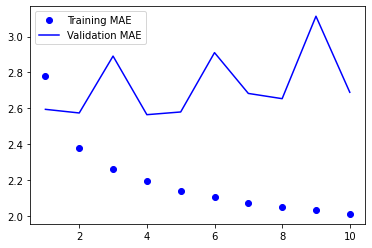

In [65]:
# evaluate dense model
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

display_loss(history)

### What about a convolutional neural network?
- As it turns out, position is *very* important when it comes to data like this
- Dense layers which lose positional information
- convolutional layers can't distinguish this information

In [0]:
# convolutional network

# the model
inputs = keras.Input((sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks=[keras.callbacks.ModelCheckpoint(filepath="jena_conv.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

405/405 [==============================] - 6s 14ms/step - loss: 16.8229 - mae: 3.2256
Test MAE: 3.23


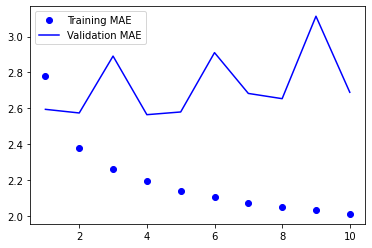

In [71]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

display_loss(history)

### The answer? Recurrent models!

In [ ]:
# recurrent LSTM-based model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()
callbacks = [keras.callbacks.ModelCheckpoint(filepath="jena_lstm.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

display_loss(history)

In [79]:
# evaluate the model
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 10s 22ms/step - loss: 10.6213 - mae: 2.5370
Test MAE: 2.54


### Well, we know a lot of regularization, so let's add some dropout and expand our model!

Epoch 1/50
819/819 [==============================] - 117s 94ms/step - loss: 30.0621 - mae: 4.0330 - val_loss: 9.7759 - val_mae: 2.4275
Epoch 2/50
819/819 [==============================] - 70s 85ms/step - loss: 15.1068 - mae: 3.0227 - val_loss: 9.4747 - val_mae: 2.3979
Epoch 3/50
819/819 [==============================] - 70s 85ms/step - loss: 14.4938 - mae: 2.9527 - val_loss: 9.1929 - val_mae: 2.3665
Epoch 4/50
819/819 [==============================] - 70s 85ms/step - loss: 14.0484 - mae: 2.9059 - val_loss: 9.1825 - val_mae: 2.3506
Epoch 5/50
819/819 [==============================] - 68s 83ms/step - loss: 13.6666 - mae: 2.8698 - val_loss: 9.0293 - val_mae: 2.3291
Epoch 6/50
819/819 [==============================] - 72s 88ms/step - loss: 13.3575 - mae: 2.8346 - val_loss: 8.9491 - val_mae: 2.3152
Epoch 7/50
819/819 [==============================] - 66s 81ms/step - loss: 13.1487 - mae: 2.8127 - val_loss: 8.9935 - val_mae: 2.3185
Epoch 8/50
819/819 [==============================] - 

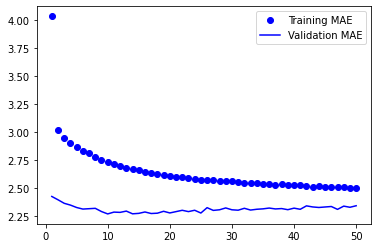

In [8]:
# A bigger model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25, unroll=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks=[keras.callbacks.ModelCheckpoint(filepath="jena_lstm_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

display_loss(history)

In [9]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}:.2f")

405/405 [==============================] - 16s 22ms/step - loss: 9.8314 - mae: 2.4786
Test MAE: 2.4786181449890137:.2f


### Stacking layers

Epoch 1/50
819/819 [==============================] - 233s 163ms/step - loss: 27.9496 - mae: 3.8876 - val_loss: 9.4976 - val_mae: 2.3731
Epoch 2/50
819/819 [==============================] - 118s 144ms/step - loss: 14.2584 - mae: 2.9248 - val_loss: 9.0448 - val_mae: 2.3299
Epoch 3/50
819/819 [==============================] - 118s 144ms/step - loss: 13.5354 - mae: 2.8531 - val_loss: 9.0625 - val_mae: 2.3412
Epoch 4/50
819/819 [==============================] - 120s 146ms/step - loss: 13.0306 - mae: 2.7988 - val_loss: 9.2525 - val_mae: 2.3701
Epoch 5/50
819/819 [==============================] - 118s 144ms/step - loss: 12.6197 - mae: 2.7555 - val_loss: 8.5650 - val_mae: 2.2685
Epoch 6/50
819/819 [==============================] - 117s 143ms/step - loss: 12.2716 - mae: 2.7213 - val_loss: 8.2869 - val_mae: 2.2308
Epoch 7/50
819/819 [==============================] - 112s 137ms/step - loss: 11.9790 - mae: 2.6863 - val_loss: 8.8135 - val_mae: 2.3131
Epoch 8/50
819/819 [=====================

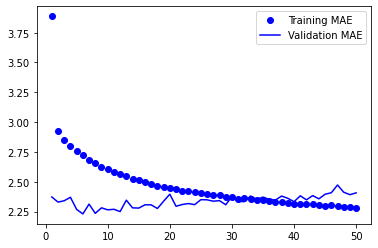

In [11]:
# stacked recurrent layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True, unroll=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5, unroll=True)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="jena_stacked_gru_dropout.keras", save_best_only=True)]
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)
display_loss(history)

### Bidirectional RNN

Epoch 1/10
819/819 [==============================] - 48s 53ms/step - loss: 27.6160 - mae: 3.7907 - val_loss: 10.6145 - val_mae: 2.5000
Epoch 2/10
819/819 [==============================] - 43s 53ms/step - loss: 9.4638 - mae: 2.4048 - val_loss: 9.6752 - val_mae: 2.4097
Epoch 3/10
819/819 [==============================] - 42s 52ms/step - loss: 8.4073 - mae: 2.2562 - val_loss: 9.8993 - val_mae: 2.4314
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 7.8549 - mae: 2.1794 - val_loss: 9.6817 - val_mae: 2.4208
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 7.5478 - mae: 2.1361 - val_loss: 10.2363 - val_mae: 2.4856
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 7.3069 - mae: 2.1013 - val_loss: 10.3534 - val_mae: 2.5059
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 7.0721 - mae: 2.0659 - val_loss: 9.9619 - val_mae: 2.4584
Epoch 8/10
819/819 [==============================] - 41s 

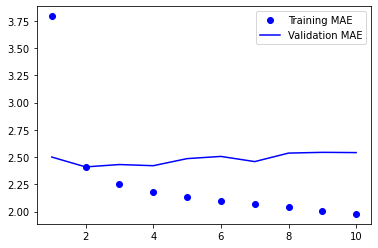

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

display_loss(history)